In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

In [2]:
# some config
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [3]:
# load in pre-trained word vector
print('Loading word vector...')
word2vec = {}
with open('/content/glove.6B.100d.txt') as f:
  # Is just a space-separted text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors: ' %len(word2vec))

Loading word vector...
Found 6118 word vectors: 


In [5]:
# load text comments dataset
from google.colab import drive
drive.mount('/content/gdrive')

import os 
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/MyDrive/kaggle_dataset'


path = '/content/gdrive/MyDrive/kaggle_dataset/toxic-comment'
if not os.path.exists(path):
    os.makedirs(path)

%cd /content/gdrive/MyDrive/kaggle_dataset/toxic-comment

Mounted at /content/gdrive
/content/gdrive/MyDrive/kaggle_dataset/toxic-comment


In [ ]:
# if the data does not exist or want to replace it

#!kaggle datasets download -d julian3833/jigsaw-toxic-comment-classification-challenge
#!unzip jigsaw-toxic-comment-classification-challenge.zip    

In [6]:
# prepare text samples and their labels
print('loading in comments...')

train = pd.read_csv('/content/gdrive/MyDrive/kaggle_dataset/toxic-comment/train.csv')
sentences = train['comment_text'].fillna('DUMMY_VALUE').values
possible_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
targets = train[possible_labels].values

print('max sequence length:', max(len(s) for s in sentences))
print('min sequence length:', min(len(s) for s in sentences))
s = sorted(len(s) for s in sentences)
print('median sequence length:', s[len(s) // 2])

loading in comments...
max sequence length: 5000
min sequence length: 6
median sequence length: 205


In [7]:
print('no of sentences in our data: %s' %len(sentences))

no of sentences in our data: 159571


In [8]:
print('first sentence:\n', sentences[0])

first sentence:
 Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


In [9]:
# convert the sentences(strings) into integers
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE) 
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [10]:
print('tokenized first sentence:\n', sequences[0])

tokenized first sentence:
 [688, 75, 1, 126, 130, 177, 29, 672, 4511, 12052, 1116, 86, 331, 51, 2278, 11448, 50, 6864, 15, 60, 2756, 148, 7, 2937, 34, 117, 1221, 15190, 2825, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3462, 89, 3085, 4583, 2273, 985]


In [11]:
# get word -> interger mapping
word2idx = tokenizer.word_index
print('found %s unique token.' %len(word2idx))

found 210337 unique token.


In [12]:
# pad sequences so that we get a N(no of sentences) * T(sequence length) matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (159571, 100)


In [13]:
# prepare embedding matrix
print('filling pre-trained embedding...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1 ) 
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))   # 20000 * 100 - V * D
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be zeros.
      embedding_matrix[i] = embedding_vector

filling pre-trained embedding...


In [14]:
# load per-trained word embeddings into an Embedding layer 
# note that we set trainable = False so as it keep embedding fixed.
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights = [embedding_matrix],
    input_length = MAX_SEQUENCE_LENGTH,
    trainable = False
)

In [19]:
print('Building model...')

# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))  # T
x = embedding_layer(input_)
#x = LSTM(15, return_sequences=True)(x)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])


print('Training model...')
h = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs= EPOCHS,
    validation_split=VALIDATION_SPLIT
)

Building model...
Training model...
Epoch 1/10
998/998 [==============================] - 19s 16ms/step - loss: 0.0972 - accuracy: 0.9788 - val_loss: 0.0860 - val_accuracy: 0.9803
Epoch 2/10
998/998 [==============================] - 13s 13ms/step - loss: 0.0822 - accuracy: 0.9889 - val_loss: 0.0825 - val_accuracy: 0.9411
Epoch 3/10
998/998 [==============================] - 12s 12ms/step - loss: 0.0792 - accuracy: 0.9868 - val_loss: 0.0809 - val_accuracy: 0.9896
Epoch 4/10
998/998 [==============================] - 12s 12ms/step - loss: 0.0774 - accuracy: 0.9869 - val_loss: 0.0808 - val_accuracy: 0.9835
Epoch 5/10
998/998 [==============================] - 12s 12ms/step - loss: 0.0758 - accuracy: 0.9853 - val_loss: 0.0791 - val_accuracy: 0.9760
Epoch 6/10
998/998 [==============================] - 12s 12ms/step - loss: 0.0745 - accuracy: 0.9822 - val_loss: 0.0809 - val_accuracy: 0.9200
Epoch 7/10
998/998 [==============================] - 12s 12ms/step - loss: 0.0735 - accuracy: 0.977

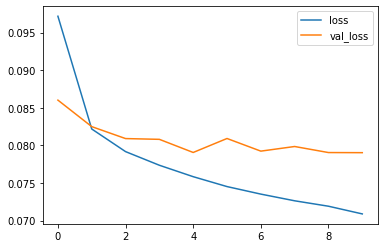

In [20]:
plt.plot(h.history['loss'] ,label='loss')
plt.plot(h.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

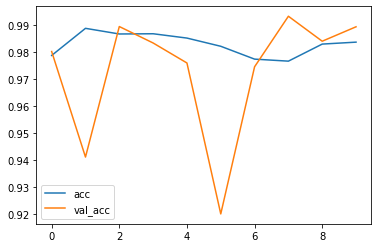

In [21]:
plt.plot(h.history['accuracy'] ,label='acc')
plt.plot(h.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [22]:
p = model.predict(data)
aucs = []
for j in range(len(possible_labels)):
  auc = roc_auc_score(targets[:, j], p[:, j])
  aucs.append(auc)

print(np.mean(aucs))

0.9601292341741875
